# Centroid Dynamics in Crucible 2

**Question:** How does the dead token cloud move as a whole during training?

We observed that the centroid norm grows from ~0.003 at t=0 to ~0.636 at t=500. This notebook explores the *character* of that motion:

1. **Centroid norm over time** — smooth asymptote? linear? something else?
2. **Path efficiency** — L2/L1 ratio of total displacement: purposeful or wandering?
3. **Trajectory curvature** — cosine similarity between consecutive displacements: straight or wiggly?
4. **Cloud spread** — does the cloud expand, contract, or stay the same size as it moves?

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Device detection
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Paths
PROJECT_ROOT = Path.cwd().parent.parent.parent
CRUCIBLE_2_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-2' / 'crucible_2_trajectory.safetensors'

# Style
plt.rcParams['figure.dpi'] = 200
STEELBLUE = '#4682B4'

# Random seed
torch.manual_seed(42)
np.random.seed(42)

Using device: mps


In [2]:
# Load Crucible 2 trajectory data
tensors = load_file(CRUCIBLE_2_PATH)

# Convert W from uint16 bitpattern back to bfloat16, then to float32
W_uint16 = tensors['W']  # [501, 3699, 64]
W = W_uint16.view(torch.bfloat16).float()

n_steps = W.shape[0]  # 501 (t=0 to t=500)
n_tokens = W.shape[1]  # 3699 dead tokens
n_dims = W.shape[2]    # 64 dimensions (projected)

print(f"Loaded trajectory: {n_steps} timesteps, {n_tokens} tokens, {n_dims} dimensions")
print(f"W shape: {W.shape}, dtype: {W.dtype}")

Loaded trajectory: 501 timesteps, 3699 tokens, 64 dimensions
W shape: torch.Size([501, 3699, 64]), dtype: torch.float32


## 1. Centroid Norm Over Time

The centroid is the mean position of all dead tokens at each timestep. How does its distance from the origin evolve?

In [3]:
# Compute centroid at each timestep
centroid = W.mean(dim=1)  # [501, 64]

# Centroid norm (distance from origin)
centroid_norm = centroid.norm(dim=1)  # [501]

# Displacement from initial position
centroid_displacement = centroid - centroid[0]  # [501, 64]
displacement_from_start = centroid_displacement.norm(dim=1)  # [501]

print(f"Centroid at t=0: norm = {centroid_norm[0].item():.6f}")
print(f"Centroid at t=500: norm = {centroid_norm[-1].item():.6f}")
print(f"Total displacement from start: {displacement_from_start[-1].item():.6f}")

Centroid at t=0: norm = 0.002889
Centroid at t=500: norm = 0.635706
Total displacement from start: 0.635538


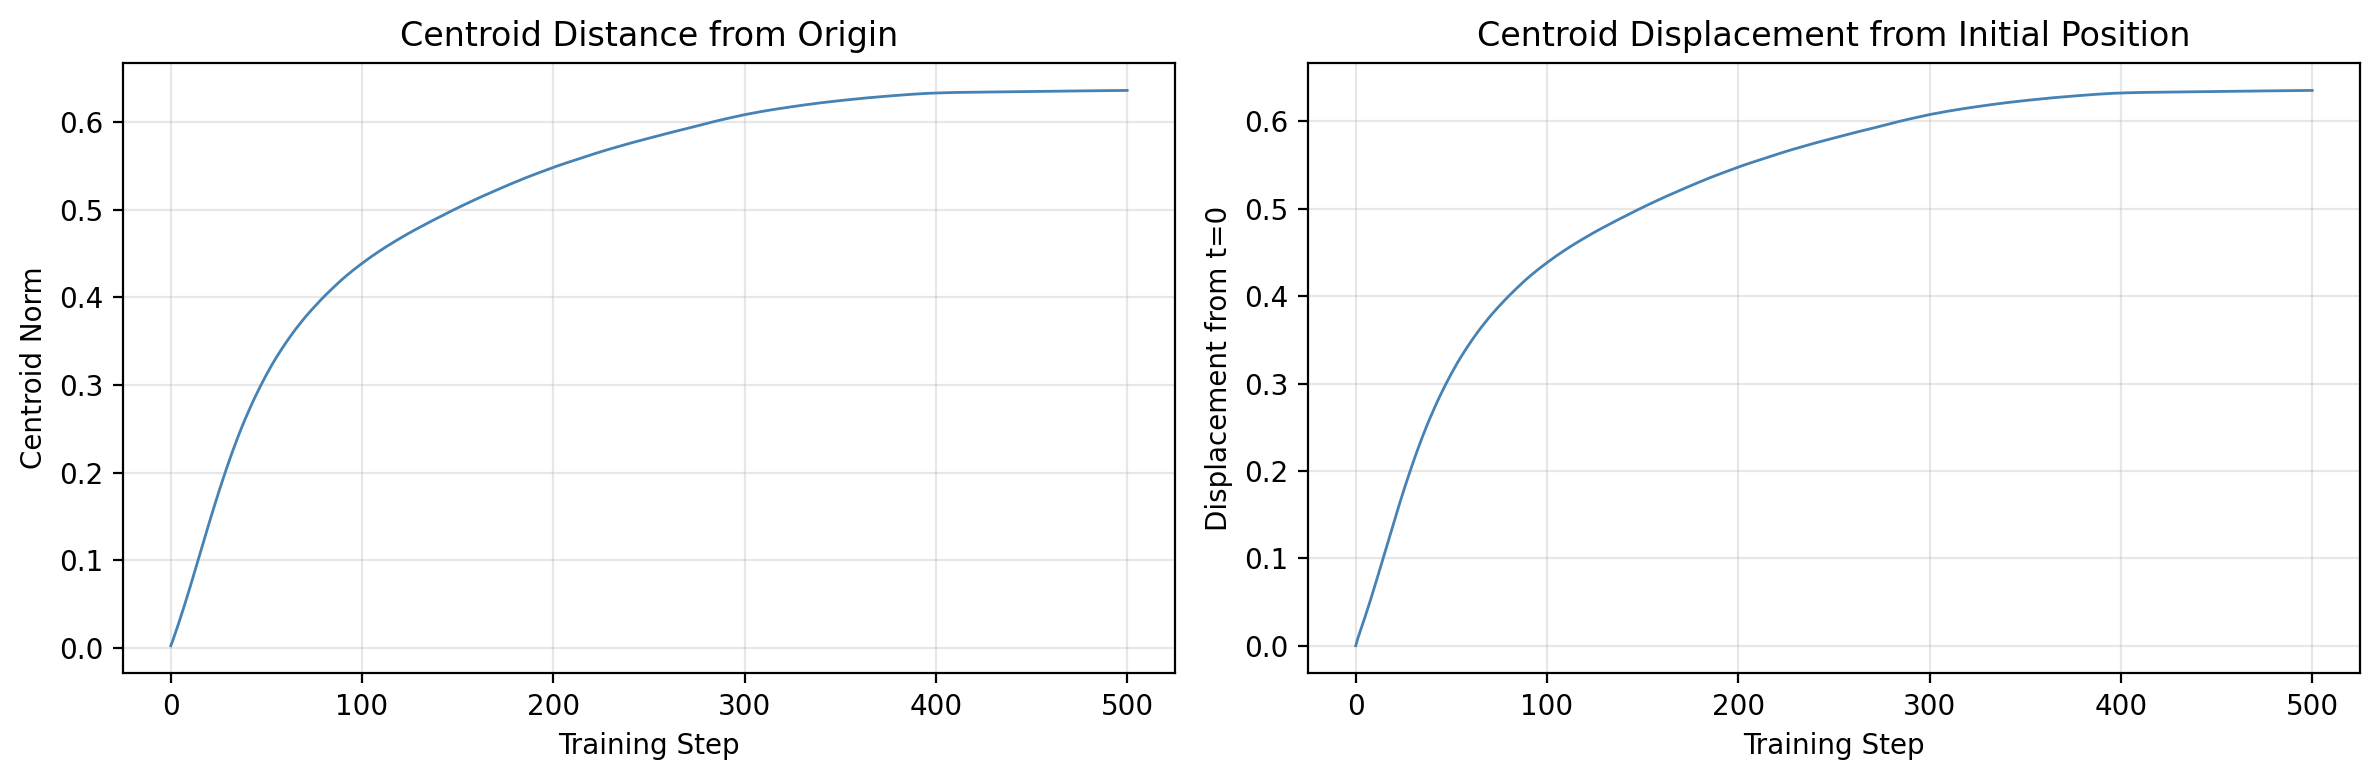

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Centroid norm (distance from origin)
ax = axes[0]
ax.plot(range(n_steps), centroid_norm.numpy(), color=STEELBLUE, linewidth=1)
ax.set_xlabel('Training Step')
ax.set_ylabel('Centroid Norm')
ax.set_title('Centroid Distance from Origin')
ax.grid(True, alpha=0.3)

# Right: Displacement from starting position
ax = axes[1]
ax.plot(range(n_steps), displacement_from_start.numpy(), color=STEELBLUE, linewidth=1)
ax.set_xlabel('Training Step')
ax.set_ylabel('Displacement from t=0')
ax.set_title('Centroid Displacement from Initial Position')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Path Efficiency

**Question:** Did the centroid take a direct path, or did it wander?

We measure this two ways:

### 2a. Displacement Efficiency
Ratio of crow-flies distance to path length traveled:
- **Efficiency = 1**: perfectly straight line
- **Efficiency → 0**: wandering drunkard

### 2b. Directional Concentration (L2/L1 ratio)
For the total displacement vector, how concentrated is the motion across dimensions?
- High ratio: motion concentrated in few dimensions (purposeful direction)
- Low ratio: motion spread across many dimensions (isotropic drift)

In [5]:
# Step-by-step displacements
step_displacements = centroid[1:] - centroid[:-1]  # [500, 64]
step_distances = step_displacements.norm(dim=1)    # [500]

# Total path length (sum of all step distances)
total_path_length = step_distances.sum().item()

# Crow-flies distance (start to end)
crow_flies = displacement_from_start[-1].item()

# Path efficiency
path_efficiency = crow_flies / total_path_length

print(f"Total path length: {total_path_length:.6f}")
print(f"Crow-flies distance: {crow_flies:.6f}")
print(f"Path efficiency: {path_efficiency:.4f} (1.0 = straight line)")

Total path length: 0.759874
Crow-flies distance: 0.635538
Path efficiency: 0.8364 (1.0 = straight line)


In [6]:
# Directional concentration of total displacement
total_displacement = centroid[-1] - centroid[0]  # [64]

# L2 norm (Euclidean)
L2 = total_displacement.norm(p=2).item()

# L1 norm (Manhattan)
L1 = total_displacement.abs().sum().item()

# Ratio (normalized for 64 dimensions)
# For a uniform vector, L2/L1 = 1/sqrt(d) ≈ 0.125 for d=64
# For a 1-hot vector, L2/L1 = 1
L2_L1_ratio = L2 / L1
uniform_baseline = 1 / np.sqrt(n_dims)

print(f"L2 norm: {L2:.6f}")
print(f"L1 norm: {L1:.6f}")
print(f"L2/L1 ratio: {L2_L1_ratio:.4f}")
print(f"Uniform baseline (1/√64): {uniform_baseline:.4f}")
print(f"Concentration above uniform: {L2_L1_ratio / uniform_baseline:.2f}x")

L2 norm: 0.635538
L1 norm: 4.820786
L2/L1 ratio: 0.1318
Uniform baseline (1/√64): 0.1250
Concentration above uniform: 1.05x


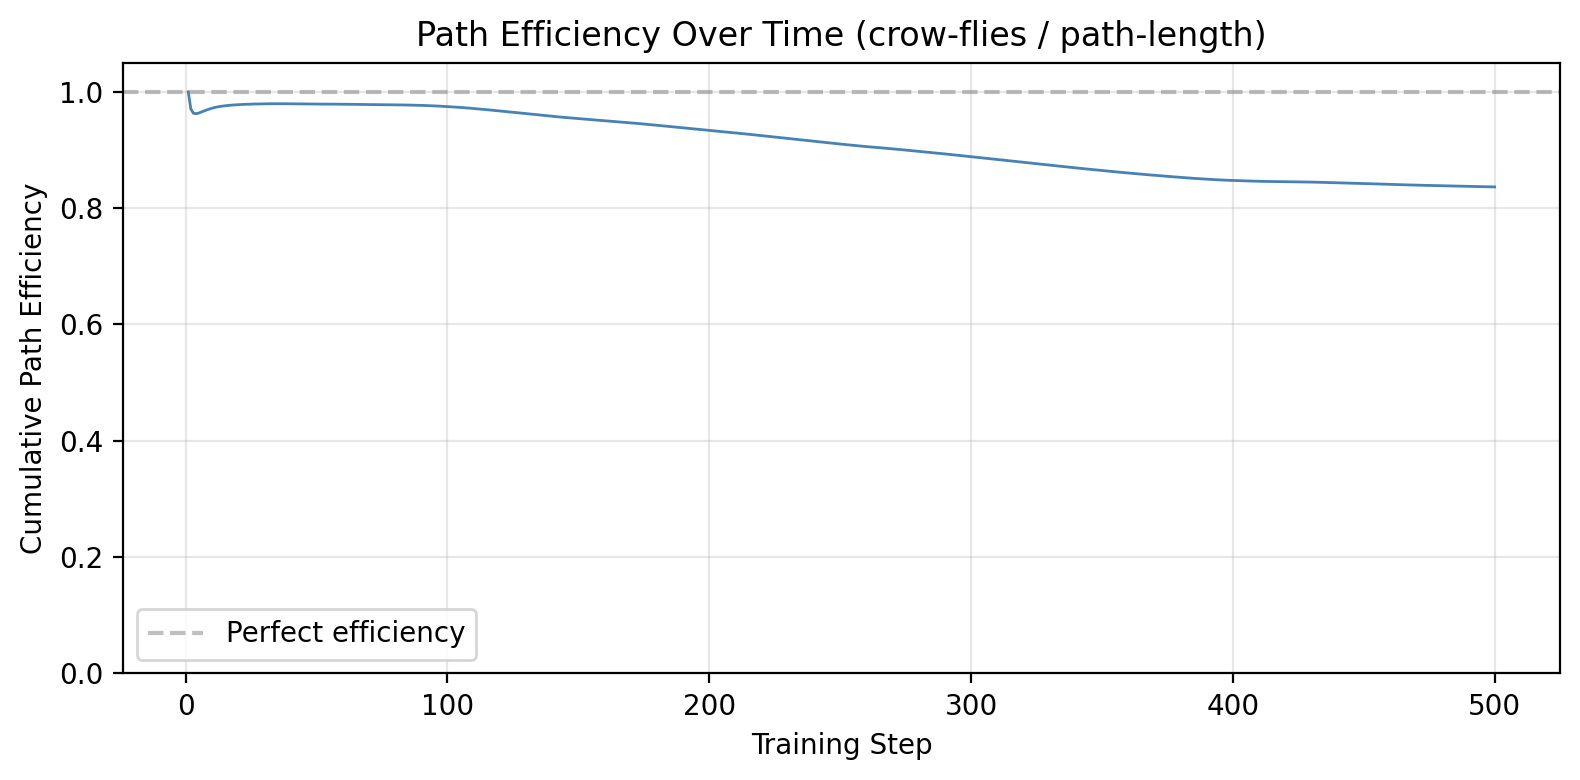

In [7]:
# Cumulative path efficiency over time
cumulative_path_length = step_distances.cumsum(dim=0)  # [500]
cumulative_efficiency = displacement_from_start[1:] / cumulative_path_length  # [500]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, n_steps), cumulative_efficiency.numpy(), color=STEELBLUE, linewidth=1)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Perfect efficiency')
ax.set_xlabel('Training Step')
ax.set_ylabel('Cumulative Path Efficiency')
ax.set_title('Path Efficiency Over Time (crow-flies / path-length)')
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

## 3. Trajectory Curvature

**Question:** How straight or wiggly is the centroid's path at each moment?

We compute the cosine similarity between consecutive displacement vectors:
- **cos = 1**: continuing straight ahead
- **cos = 0**: turning 90 degrees
- **cos = -1**: reversing direction

In [8]:
# Consecutive displacement vectors
d_prev = step_displacements[:-1]  # [499, 64]
d_curr = step_displacements[1:]   # [499, 64]

# Cosine similarity between consecutive steps
# cos(θ) = (a · b) / (|a| |b|)
dot_products = (d_prev * d_curr).sum(dim=1)  # [499]
norms_prev = d_prev.norm(dim=1)  # [499]
norms_curr = d_curr.norm(dim=1)  # [499]

# Avoid division by zero
denom = norms_prev * norms_curr
denom = torch.clamp(denom, min=1e-8)

cosine_similarity = dot_products / denom  # [499]

print(f"Mean cosine similarity: {cosine_similarity.mean().item():.4f}")
print(f"Std cosine similarity: {cosine_similarity.std().item():.4f}")
print(f"Min: {cosine_similarity.min().item():.4f}, Max: {cosine_similarity.max().item():.4f}")

Mean cosine similarity: 0.9881
Std cosine similarity: 0.0708
Min: 0.3281, Max: 1.0000


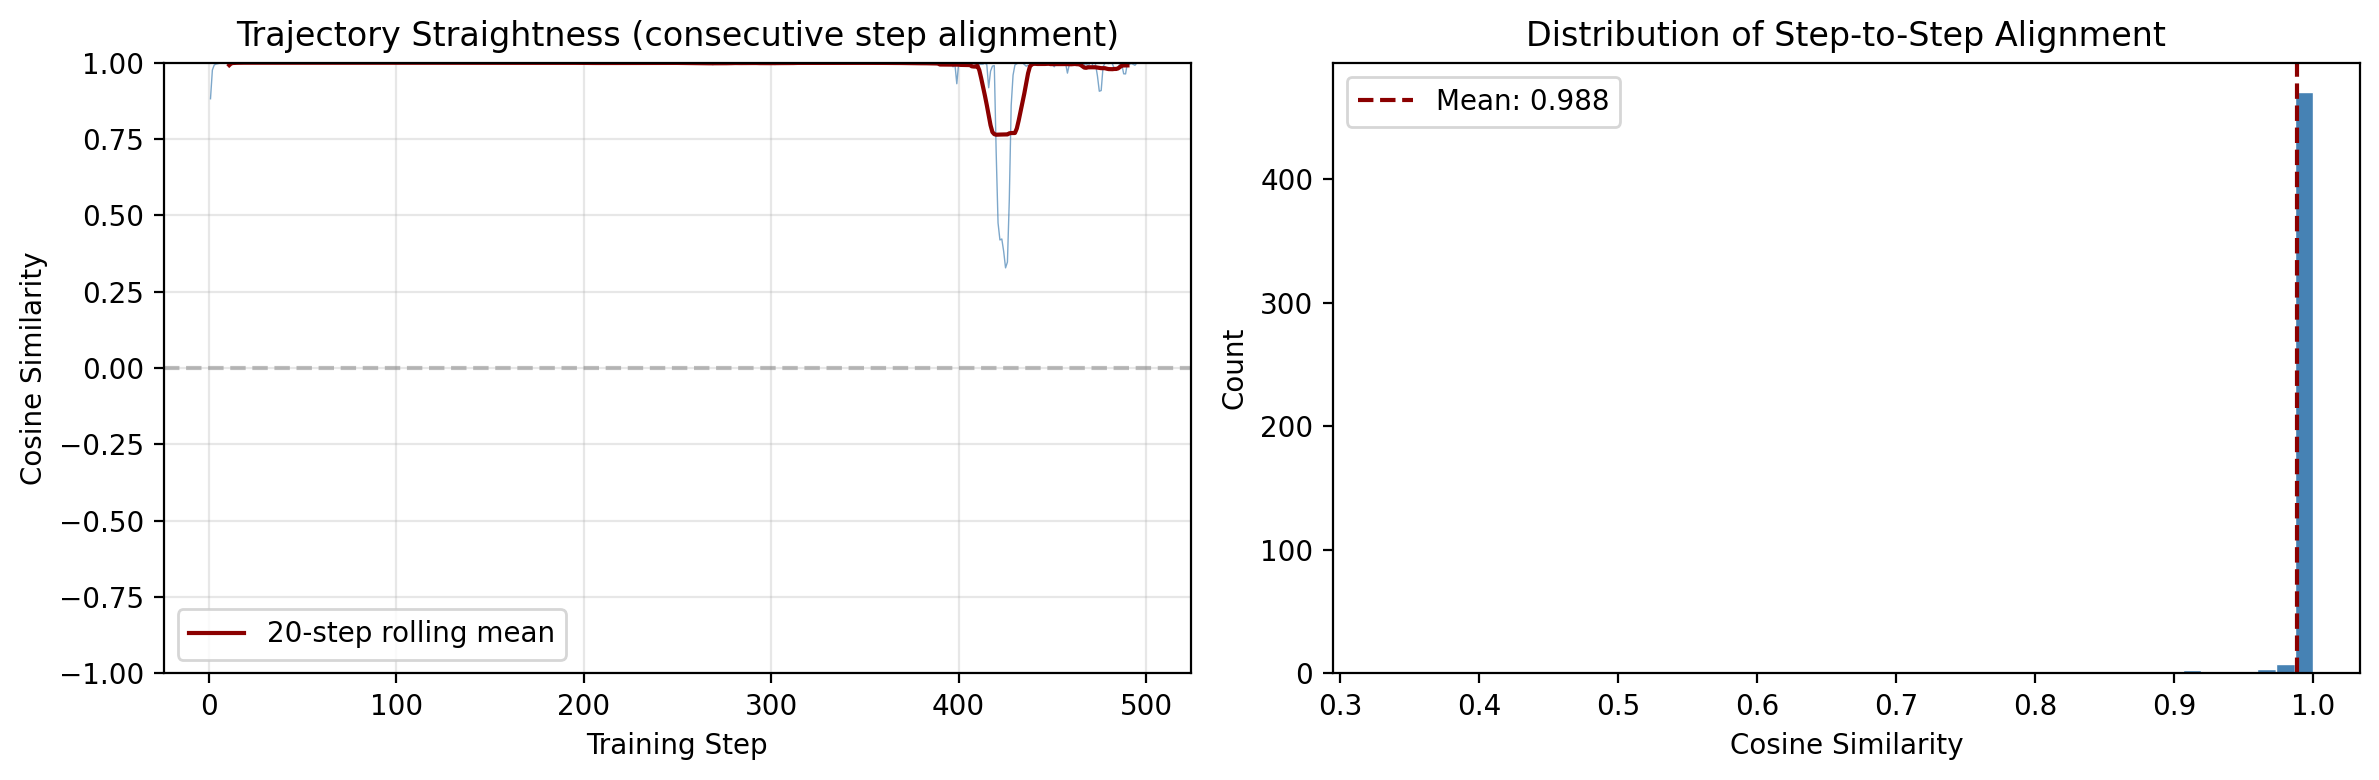

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Curvature over time
ax = axes[0]
ax.plot(range(1, 500), cosine_similarity.numpy(), color=STEELBLUE, linewidth=0.5, alpha=0.7)
# Rolling mean for clarity
window = 20
rolling_mean = np.convolve(cosine_similarity.numpy(), np.ones(window)/window, mode='valid')
ax.plot(range(1 + window//2, 500 - window//2 + 1), rolling_mean, color='darkred', linewidth=1.5, label=f'{window}-step rolling mean')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Training Step')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Trajectory Straightness (consecutive step alignment)')
ax.set_ylim(-1, 1)
ax.grid(True, alpha=0.3)
ax.legend()

# Right: Histogram of cosine similarities
ax = axes[1]
ax.hist(cosine_similarity.numpy(), bins=50, color=STEELBLUE, edgecolor='white', linewidth=0.5)
ax.axvline(x=cosine_similarity.mean().item(), color='darkred', linestyle='--', label=f'Mean: {cosine_similarity.mean().item():.3f}')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Count')
ax.set_title('Distribution of Step-to-Step Alignment')
ax.legend()

plt.tight_layout()
plt.show()

## 4. Cloud Spread

**Question:** As the centroid moves, does the cloud expand, contract, or stay the same size?

We measure the "spread" as the mean distance of tokens from the centroid (like a radius).

In [10]:
# Distance of each token from the centroid at each timestep
# W: [501, 3699, 64], centroid: [501, 64]
distances_from_centroid = (W - centroid.unsqueeze(1)).norm(dim=2)  # [501, 3699]

# Mean distance (cloud "radius")
mean_radius = distances_from_centroid.mean(dim=1)  # [501]

# Std of distances (spread uniformity)
std_radius = distances_from_centroid.std(dim=1)  # [501]

print(f"Mean radius at t=0: {mean_radius[0].item():.6f}")
print(f"Mean radius at t=500: {mean_radius[-1].item():.6f}")
print(f"Ratio: {mean_radius[-1].item() / mean_radius[0].item():.4f}x")

Mean radius at t=0: 0.159258
Mean radius at t=500: 0.094967
Ratio: 0.5963x


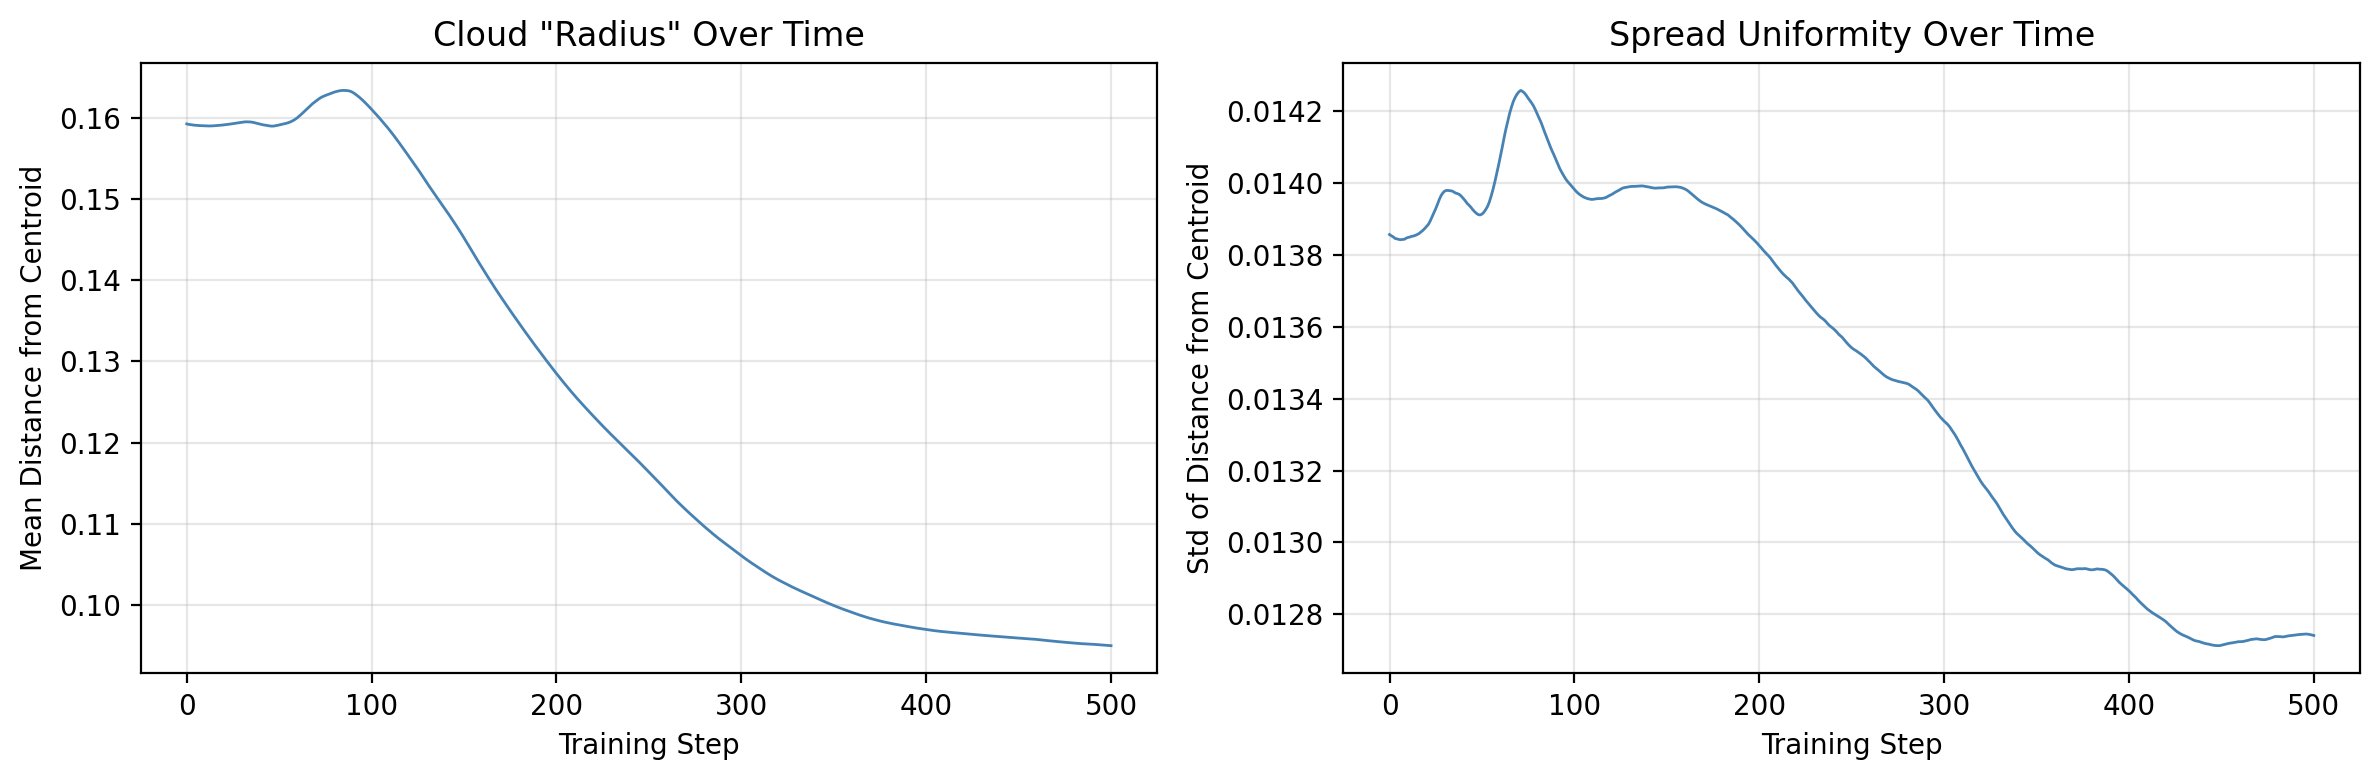

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Mean radius over time
ax = axes[0]
ax.plot(range(n_steps), mean_radius.numpy(), color=STEELBLUE, linewidth=1)
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Distance from Centroid')
ax.set_title('Cloud "Radius" Over Time')
ax.grid(True, alpha=0.3)

# Right: Std of radius (uniformity of spread)
ax = axes[1]
ax.plot(range(n_steps), std_radius.numpy(), color=STEELBLUE, linewidth=1)
ax.set_xlabel('Training Step')
ax.set_ylabel('Std of Distance from Centroid')
ax.set_title('Spread Uniformity Over Time')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Summary Statistics

In [12]:
print("=" * 60)
print("CENTROID DYNAMICS SUMMARY")
print("=" * 60)
print(f"\nDataset: Crucible 2 (500 steps, {n_tokens} dead tokens)")
print(f"\n--- Centroid Position ---")
print(f"  Initial norm: {centroid_norm[0].item():.6f}")
print(f"  Final norm: {centroid_norm[-1].item():.6f}")
print(f"  Total displacement: {crow_flies:.6f}")
print(f"\n--- Path Character ---")
print(f"  Path length traveled: {total_path_length:.6f}")
print(f"  Path efficiency: {path_efficiency:.4f}")
print(f"  L2/L1 ratio: {L2_L1_ratio:.4f} ({L2_L1_ratio/uniform_baseline:.2f}x uniform)")
print(f"\n--- Trajectory Curvature ---")
print(f"  Mean cosine similarity: {cosine_similarity.mean().item():.4f}")
print(f"  Std: {cosine_similarity.std().item():.4f}")
print(f"\n--- Cloud Spread ---")
print(f"  Initial radius: {mean_radius[0].item():.6f}")
print(f"  Final radius: {mean_radius[-1].item():.6f}")
print(f"  Expansion ratio: {mean_radius[-1].item() / mean_radius[0].item():.4f}x")
print("=" * 60)

CENTROID DYNAMICS SUMMARY

Dataset: Crucible 2 (500 steps, 3699 dead tokens)

--- Centroid Position ---
  Initial norm: 0.002889
  Final norm: 0.635706
  Total displacement: 0.635538

--- Path Character ---
  Path length traveled: 0.759874
  Path efficiency: 0.8364
  L2/L1 ratio: 0.1318 (1.05x uniform)

--- Trajectory Curvature ---
  Mean cosine similarity: 0.9881
  Std: 0.0708

--- Cloud Spread ---
  Initial radius: 0.159258
  Final radius: 0.094967
  Expansion ratio: 0.5963x
